In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv("../data/final/dataset.csv", parse_dates=["Date"], index_col="Date")

<h1 style="color: red;">Log Transformation</h1>

In [3]:
# list out negative values columns

import numpy as np

# Step 1: Select numeric columns
suitable_col = [
    'hash_rate_blockchain',  
    'btc_sma_14', 'btc_ema_14', 
    'btc_bb_high', 'btc_bb_low', 'btc_bb_mid', 'btc_bb_width', 
    'btc_atr_14', 'btc_trading_volume', 'btc_volatility_index',
    'ARK Innovation ETF', 'CBOE Volatility Index', 'Shanghai Composite Index', 
    'btc_close'
]

# Step 2: Identify columns with negative values
print("Columns with negative values and their respective rows:")
for col in suitable_col:
    negative_rows = df[df[col] < 0]
    if not negative_rows.empty:
        print(f"\nColumn: {col}")
        print("Rows with negative values:")
        print(negative_rows[[col]])  # Print only the column with negatives for clarity

Columns with negative values and their respective rows:


In [4]:
# Apply log transformation for suitable columns
df[suitable_col] = df[suitable_col].map(lambda x: np.log(x + 1) if x >= 0 else np.nan)

print("Sample transformed data (first 5 rows):")
df[suitable_col].head()

Sample transformed data (first 5 rows):


,hash_rate_blockchain,btc_sma_14,btc_ema_14,btc_bb_high,btc_bb_low,btc_bb_mid,btc_bb_width,btc_atr_14,btc_trading_volume,btc_volatility_index,ARK Innovation ETF,CBOE Volatility Index,Shanghai Composite Index,btc_close
Date,,,,,,,,,,,,,,
2014-11-16 00:00:00+00:00,12.561870,5.920515,5.925861,5.975114,5.871384,5.924593,2.432869,2.942863,16.292520,2.844736,3.065258,2.660959,7.816088,5.963276
2014-11-17 00:00:00+00:00,12.609017,5.920515,5.925861,5.975114,5.871384,5.924593,2.432869,2.942863,17.541657,3.517409,3.063858,2.707383,7.814448,5.962056
2014-11-18 00:00:00+00:00,12.595772,5.920515,5.925861,5.975114,5.871384,5.924593,2.432869,2.942863,17.288176,3.103914,3.072693,2.698673,7.807319,5.930116
2014-11-19 00:00:00+00:00,12.522548,5.920515,5.925861,5.975114,5.871384,5.924593,2.432869,2.942863,16.756354,2.608966,3.058238,2.705380,7.804727,5.944255
2014-11-20 00:00:00+00:00,12.522548,5.920515,5.925861,5.975114,5.871384,5.924593,2.432869,2.942863,17.043671,3.267437,3.057768,2.679651,7.805319,5.882877


<h1 style="color: red;">Address Multicollinearity</h1>

In [8]:
# Split the dataset into train (60%), validation (20%), and test (20%)
train_split = int(len(df) * 0.6)
val_split = int(len(df) * 0.8)

train_data = df.iloc[:train_split]
val_data = df.iloc[train_split:val_split]
test_data = df.iloc[val_split:]

# Select features and target
X_train = train_data.drop(columns=['btc_close']).values
y_train = train_data['btc_close'].values

X_val = val_data.drop(columns=['btc_close']).values
y_val = val_data['btc_close'].values

X_test = test_data.drop(columns=['btc_close']).values
y_test = test_data['btc_close'].values

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on the training data
X_val_scaled = scaler.transform(X_val)  # Transform validation data using the same scaler
X_test_scaled = scaler.transform(X_test)  # Transform test data using the same scaler

# Save the scaler
joblib.dump(scaler, "models/scaler.pkl")

# Fit PCA on the training set
pca = PCA()
pca.fit(X_train_scaled)

# Determine the optimal number of components (k)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_k = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components (k): {optimal_k}")

# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_k)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# SAve PCA
joblib.dump(pca, "models/pca.pkl")

# Create DataFrames for the PCA-transformed data
train_pca_df = pd.DataFrame(
    X_train_pca,
    columns=[f'pca_{i+1}' for i in range(optimal_k)],
    index=train_data.index
)
train_pca_df['btc_close'] = y_train

val_pca_df = pd.DataFrame(
    X_val_pca,
    columns=[f'pca_{i+1}' for i in range(optimal_k)],
    index=val_data.index
)
val_pca_df['btc_close'] = y_val

test_pca_df = pd.DataFrame(
    X_test_pca,
    columns=[f'pca_{i+1}' for i in range(optimal_k)],
    index=test_data.index
)
test_pca_df['btc_close'] = y_test

# Print results
print("Train PCA DataFrame:")
print(train_pca_df.head())
print("\nValidation PCA DataFrame:")
print(val_pca_df.head())
print("\nTest PCA DataFrame:")
print(test_pca_df.head())


Optimal number of components (k): 9
Train PCA DataFrame:
                              pca_1     pca_2     pca_3     pca_4     pca_5  \
Date                                                                          
2014-11-16 00:00:00+00:00 -4.121992 -3.232977 -2.401240  1.728765  0.381897   
2014-11-17 00:00:00+00:00 -3.981510 -3.164071 -2.451992  1.665308  0.541560   
2014-11-18 00:00:00+00:00 -4.038843 -3.051439 -2.449070  1.724378  0.483461   
2014-11-19 00:00:00+00:00 -4.160178 -3.154693 -2.478618  1.826985  0.485023   
2014-11-20 00:00:00+00:00 -4.040298 -3.223597 -2.493367  1.746435  0.508177   

                              pca_6     pca_7     pca_8     pca_9  btc_close  
Date                                                                          
2014-11-16 00:00:00+00:00 -2.366234  1.569413  1.622955 -0.465726   5.963276  
2014-11-17 00:00:00+00:00 -2.279307  1.478371  1.741167 -0.322292   5.962056  
2014-11-18 00:00:00+00:00 -2.444774  1.611868  1.532040 -0.372835   5.930

In [9]:
# Print cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.5330662  0.63548968 0.73261393 0.78793565 0.83286065 0.87266154
 0.90716223 0.93665245 0.95415317]


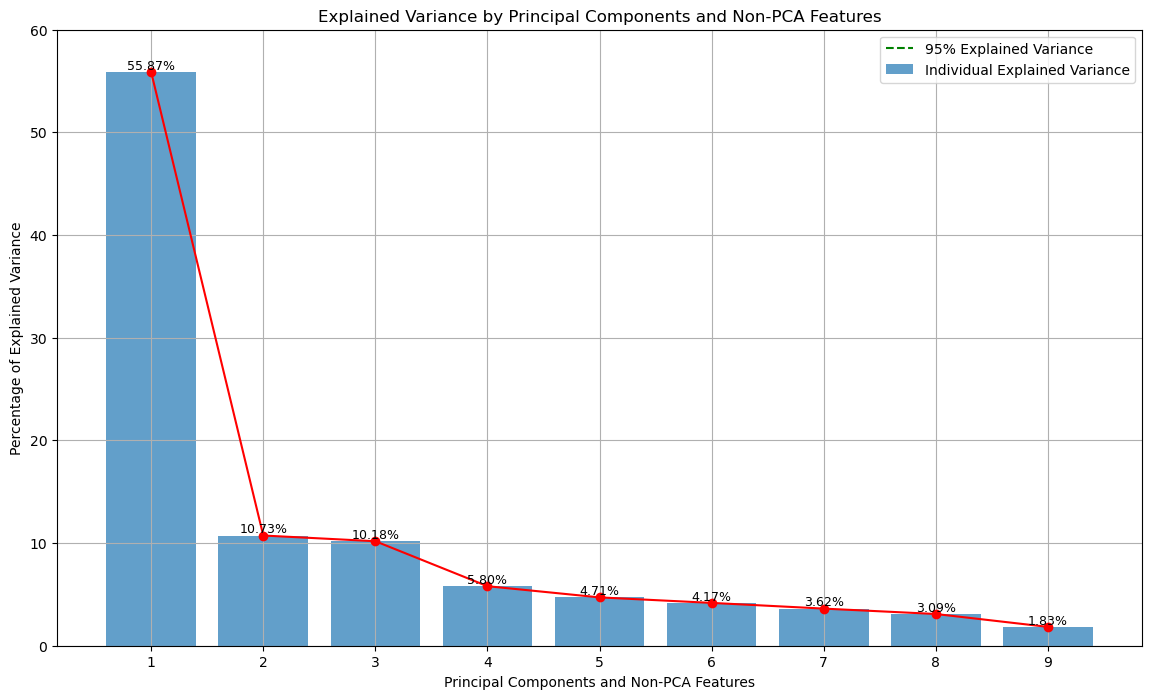

In [10]:
used_explained_variance_ratios = np.concatenate([
    pca.explained_variance_ratio_
])

# Normalize to sum to 1
used_explained_variance_ratios /= used_explained_variance_ratios.sum()

# Step 3: Create explained variance plot
plt.figure(figsize=(14, 8))

# Bar plot for individual explained variance
bars = plt.bar(
    range(1, len(used_explained_variance_ratios) + 1),
    used_explained_variance_ratios * 100,  # Convert to percentage
    alpha=0.7,
    label="Individual Explained Variance"
)

# Add percentage labels on top of each bar
for bar, percentage in zip(bars, used_explained_variance_ratios * 100):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Line plot for cumulative explained variance
plt.plot(
    range(1, len(used_explained_variance_ratios) + 1),
    used_explained_variance_ratios * 100,
    marker='o',
    color='red',
    # label="Cumulative Explained Variance"
)

# Add thresholds and limits
plt.axhline(95, color='green', linestyle='--', label='95% Explained Variance')  # 95% threshold line
plt.ylim(0, 60)  # Limit Y-axis to 100%
plt.xticks(range(1, len(used_explained_variance_ratios) + 1))  # Match X-axis to number of components

plt.title('Explained Variance by Principal Components and Non-PCA Features')
plt.xlabel('Principal Components and Non-PCA Features')
plt.ylabel('Percentage of Explained Variance')
plt.legend(loc='best')
plt.grid()
plt.show()

### Export pca data to csv

In [11]:
train_pca_df.to_csv("../data/final/train_pca_df.csv")
val_pca_df.to_csv("../data/final/val_pca_df.csv")
test_pca_df.to_csv("../data/final/test_pca_df.csv")